<a href="https://colab.research.google.com/github/Masanova-Ksenia/1-Module-Task/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_1_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B1%D1%83%D0%BA%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras

In [ ]:
import tensorflow_datasets as tfds

# Загрузка набора данных EMNIST с разбиением 'ByClass'
# as_supervised=True возвращает кортеж (img, label)
# with_info=True возвращает информацию о наборе данных
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Фильтруем набор данных, оставляя только заглавные буквы.
# Согласно документации EMNIST, заглавные буквы «A»-«Z» имеют метки 10-35.
def filter_uppercase(image, label):
    return tf.logical_and(label >= 10, label <= 35)

ds_train_uppercase = ds_train.filter(filter_uppercase)
ds_test_uppercase = ds_test.filter(filter_uppercase)

# Вывести информацию о загруженных и отфильтрованных наборах данных
print("EMNIST ByClass dataset info:")
print(ds_info)
print("\nКоличество выборок в отфильтрованном обучающем наборе данных (заглавными буквами):")
print(tf.data.experimental.cardinality(ds_train_uppercase).numpy())
print("\nКоличество выборок в отфильтрованном тестовом наборе данных (заглавными буквами):")
print(tf.data.experimental.cardinality(ds_test_uppercase).numpy())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.VBAMU0_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.VBAMU0_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
EMNIST ByClass dataset info:
tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/byclass/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByClass
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/root/tensorflow_datasets/emnist/byclass/3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=Feature

In [ ]:
# Определить преобразования для исправления ориентации изображения и нормализации значений пикселей.
# Изображения EMNIST повёрнуты на 90 градусов против часовой стрелки и перевёрнуты по горизонтали.
def preprocess_image(image, label):
  # Повернуть изображение на 90 градусов по часовой стрелке (чтобы избежать поворота на 90 градусов против часовой стрелки)
  image = tf.image.rot90(image, k=3)
  # Отразить изображение по горизонтали (чтобы избежать поворота по горизонтали)
  image = tf.image.flip_left_right(image)
  # Преобразовать изображение в float32 и масштабировать значения пикселей до [0, 1]
  image = tf.cast(image, tf.float32) / 255.0
  # Сопоставить метки 10-35 с 0-25
  label = label - 10
  return image, label

# Применить функцию предварительной обработки к отфильтрованным наборам данных
ds_train_processed = ds_train_uppercase.map(preprocess_image)
ds_test_processed = ds_test_uppercase.map(preprocess_image)

# Чтобы проверить количество выборок и проверить некоторые примеры, мы можем итерировать набор данных.
# Это необходимо для проверки и может быть медленным для больших наборов данных.
# Более эффективный способ получить приблизительный размер — проверить SplitInfo, но фильтрация изменяет размер.

# Мы можем взять небольшой пакет для проверки, а затем, при необходимости, явно рассчитать размер позже.

# Давайте возьмём небольшой пакет для проверки структуры и содержимого.
print("\nПроверка небольшой партии из обработанного обучающего набора данных:")
for image_batch, label_batch in ds_train_processed.take(1):
  print("Форма партии изображений:", image_batch.shape)
  print("Форма партии меток:", label_batch.shape)
  print("Метки выборок:", label_batch.numpy())

# Явно подсчитываем количество выборок в отфильтрованных наборах данных для проверки
train_count = ds_train_uppercase.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
test_count = ds_test_uppercase.reduce(tf.constant(0), lambda x, _: x + 1).numpy()

print(f"\nЯвно подсчитанные выборки в отфильтрованном обучающем наборе данных (в верхнем регистре): {train_count}")
print(f"Явно подсчитанные выборки в отфильтрованном тестовом наборе данных (заглавными буквами): {test_count}")


Проверка небольшой партии из обработанного обучающего набора данных:
Форма партии изображений: (28, 28, 1)
Форма партии меток: ()
Метки выборок: 21

Явно подсчитанные выборки в отфильтрованном обучающем наборе данных (в верхнем регистре): 188958
Явно подсчитанные выборки в отфильтрованном тестовом наборе данных (заглавными буквами): 31346


In [ ]:
# Применить прямое кодирование к меткам
# Количество классов для заглавных букв — 26 (A–Z)
num_classes = 26

def one_hot_encode(image, label):
  return image, tf.one_hot(label, num_classes)

ds_train_encoded = ds_train_processed.map(one_hot_encode)
ds_test_encoded = ds_test_processed.map(one_hot_encode)

# Инструкция 5: Применить буферизацию и предварительную выборку
BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32 # Определить размер пакета

ds_train_final = ds_train_encoded.cache().shuffle(train_count).batch(BATCH_SIZE).prefetch(BUFFER_SIZE)
ds_test_final = ds_test_encoded.cache().batch(BATCH_SIZE).prefetch(BUFFER_SIZE) # Перемешивать тестовый набор не нужно

# Проверить структуру и содержимое финальных наборов данных
print("\nПроверка небольшого пакета из финального подготовленного обучающего набора данных:")
for image_batch, label_batch in ds_train_final.take(1):
  print("Форма пакета изображений:", image_batch.shape)
  print("Форма пакета меток:", label_batch.shape)
  print("Выборка меток с прямым кодированием (первые 5):", label_batch.numpy()[:5])

print("\nПроверка небольшого пакета из финального подготовленного тестового набора данных набор данных:")
for image_batch, label_batch in ds_test_final.take(1):
  print("Форма пакета изображений:", image_batch.shape)
  print("Форма пакета этикеток:", label_batch.shape)
  print("Примеры меток с прямым кодированием (первые 5):", label_batch.numpy()[:5])


Проверка небольшого пакета из финального подготовленного обучающего набора данных:
Форма пакета изображений: (32, 28, 28, 1)
Форма пакета меток: (32, 26)
Выборка меток с прямым кодированием (первые 5): [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]

Проверка небольшого пакета из финального подготовленного тестового набора данных набор данных:
Форма пакета изображений: (32, 28, 28, 1)
Форма пакета этикеток: (32, 26)
Примеры меток с прямым кодированием (первые 5): [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape

# Определить архитектуру модели
model = Sequential([
  # Добавить слой Reshape для явного определения входной формы как (28, 28, 1)
  Reshape(target_shape=(28, 28, 1), input_shape=(28, 28)),
  Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax') # num_classes равно 26 для заглавных букв
])

# Отобразить сводку модели
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,706 (1.62 MB)

 Trainable params: 423,706 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

# Оптимизатор (например, adam)
optimizer = Adam()

# Функция потерь для многоклассовой классификации (CategoricalCrossentropy)
# Использование from_logits=False, поскольку выходной слой использует активацию softmax
loss_fn = CategoricalCrossentropy(from_logits=False)

# Выбор метрики для оценки эффективности модели (например, precision)
metrics = ['accuracy']

# Компиляция модели
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)

print("Модель успешно скомпилирована с оптимизатором Adam, CategoricalCrossentropy loss и Accuracy метрика.")

Модель успешно скомпилирована с оптимизатором Adam, CategoricalCrossentropy loss и Accuracy метрика.


In [ ]:
# Определение количества эпох обучения
epochs = 10 # Возможно изменение количества эпох в зависимости от желаемой точности и времени обучения

# Обучение модели и сохранение истории обучения
history = model.fit(
    ds_train_final,
    validation_data=ds_test_final,
    epochs=epochs
)

print(f"Обучение модели завершено за {epochs} эпох.")

Epoch 1/10
   5905/Unknown 268s 45ms/step - accuracy: 0.9030 - loss: 0.3504

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5905/5905 ━━━━━━━━━━━━━━━━━━━━ 295s 50ms/step - accuracy: 0.9030 - loss: 0.3504 - val_accuracy: 0.9711 - val_loss: 0.1016
Epoch 2/10
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 274s 46ms/step - accuracy: 0.9762 - loss: 0.0852 - val_accuracy: 0.9784 - val_loss: 0.0771
Epoch 3/10
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 271s 46ms/step - accuracy: 0.9831 - loss: 0.0606 - val_accuracy: 0.9795 - val_loss: 0.0763
Epoch 4/10
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 323s 46ms/step - accuracy: 0.9859 - loss: 0.0482 - val_accuracy: 0.9802 - val_loss: 0.0728
Epoch 5/10
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 273s 46ms/step - accuracy: 0.9892 - loss: 0.0359 - val_accuracy: 0.9804 - val_loss: 0.0802
Epoch 6/10
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 272s 46ms/step - accuracy: 0.9905 - loss: 0.0306 - val_accuracy: 0.9793 - val_loss: 0.0865
Epoch 7/10
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 276s 47ms/step - accuracy: 0.9922 - loss: 0.0250 - val_accuracy: 0.9789 - val_loss: 0.0916
Epoch 8/10
5905/5905 ━━━━━━━━━━━━━━━━━━━━ 273s 46ms/step - accuracy: 0.9928 - lo

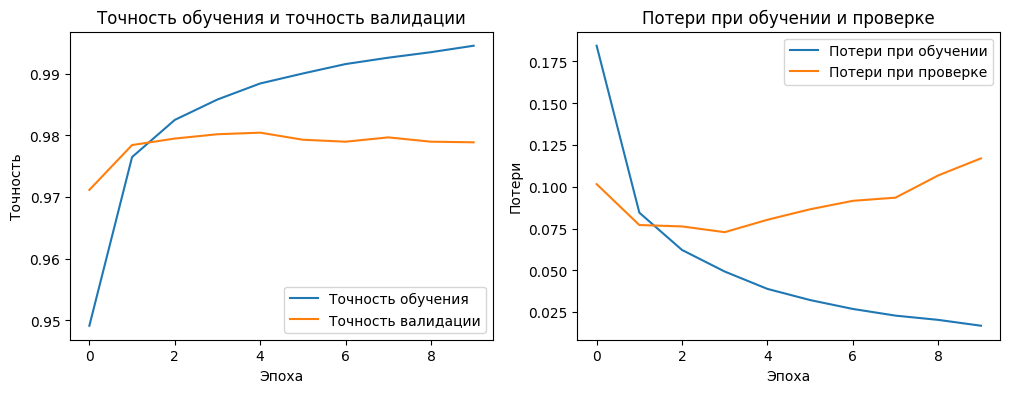

In [ ]:
# Извлечение значений точности и потерь из объекта истории
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Построение графика точности обучения и валидации
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность обучения')
plt.plot(epochs_range, val_acc, label='Точность валидации')
plt.legend(loc='lower right')
plt.title('Точность обучения и точность валидации')
plt.xlabel('Эпоха')
plt.ylabel('Точность')

# Построение графика потерь при обучении и проверке
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери при обучении')
plt.plot(epochs_range, val_loss, label='Потери при проверке')
plt.legend(loc='upper right')
plt.title('Потери при обучении и проверке')
plt.xlabel('Эпоха')
plt.ylabel('Потери')

plt.show()

In [ ]:
from PIL import Image

# Путь к тестовому изображению
user_image_path = '/content/Image2.png' # Путь должен быть корректным

try:
	# Загрузка изображения
	img = Image.open(user_image_path)

	# Преобразование в оттенки серого, если это ещё не сделано
	if img.mode != 'L':
		img = img.convert('L')

	# Изменение размера изображения до 28x28 пикселей
	img_resized = img.resize((28, 28))

	# Преобразование изображения в массив numpy
	img_array = np.array(img_resized)

	# Нормализация значений пикселей до [0, 1]
	img_normalized = img_array.astype('float32') / 255.0

	# Изменение формы массива, добавлением измерения каналов и пакетов.
	# Модель ожидает входные данные о форме (размер пакета, высота, ширина, каналы).
	img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавление измерения каналов.
	img_prepared = np.expand_dims(img_prepared, axis=0) # Добавление измерения пакетов.

	# Выведение формы подготовленного изображения.
	print("Форма подготовленного изображения:", img_prepared.shape)

	# На этом этапе изображение(img_prepared) готово к использованию в модели для прогнозирования.

except FileNotFoundError:
	print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
except Exception as e:
	print(f"Произошла ошибка во время обработки изображения: {e}")

Форма подготовленного изображения: (1, 28, 28, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Предсказанная буква: U
Отображение изображения из: /content/Image2.png


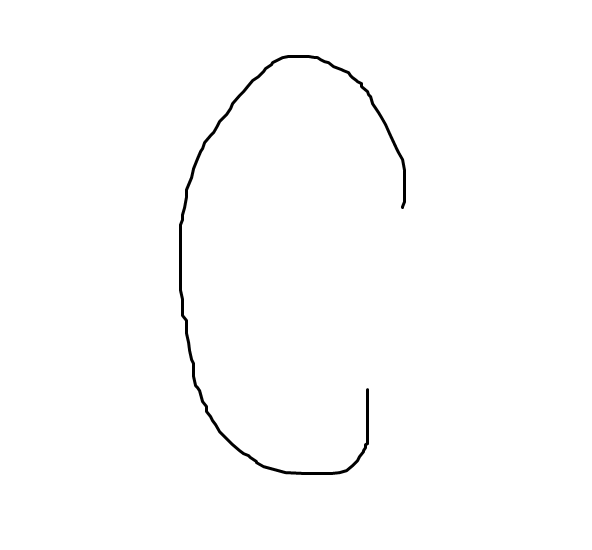

In [ ]:
from IPython.display import display

# Использование метода .predict() обученной модели на подготовленных данных изображения
predictions = model.predict(img_prepared)

# Нахождение индекса класса с наибольшей вероятностью
predicted_index = np.argmax(predictions[0])

# Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
predicted_letter = chr(predicted_index + 65)

# Выведение предсказанной буквы
print(f"Предсказанная буква: {predicted_letter}")

user_image_path = '/content/Image2.png'

try:
  # Загрузка изображения
  img = Image.open(user_image_path)
  print(f"Отображение изображения из: {user_image_path}")
  display(img)
except FileNotFoundError:
  print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
except Exception as e:
  print(f"Произошла ошибка при попытке отобразить изображение: {e}")

In [ ]:
# Определение слоя аугментации данных
# Можно использовать различные слои и параметры
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.RandomRotation(factor=0.05), # Случайный поворот изображений на 5%
	tf.keras.layers.RandomZoom(height_factor=0.05, width_factor=0.05), # Случайное увеличение/уменьшение масштаба на 5%
	tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05), # Случайный сдвиг изображений на 5%
# tf.keras.layers.RandomContrast(factor=0.1), # Случайная регулировка контрастности
])

# Функция для применения аугментации и последующей предварительной обработки
def augment_and_preprocess(image, label):

	# Для EMNIST, который является изображением в оттенках серого, мы применим аугментацию к одноканальному изображению.

	# Применение предварительной обработки (поворот, отражение, нормализация к [0,1], сопоставление меток)
	image, label = preprocess_image(image, label) # Повторно используем функцию preprocess_image, определённую ранее

	# Применяем аугментацию данных только к обучающему набору данных
	# Слои аугментации ожидают входные данные в диапазоне [0, 1] или [0, 255] в зависимости от слоя.
	# Наш preprocess_image нормализуется до [0, 1], что подходит для RandomRotation, RandomZoom и т. д.
	image = data_augmentation(image, training=True) # Важно: применять только во время обучения

	# Проверка, что изображение по-прежнему имеет 1 канал после аугментации, если слои изменяют количество каналов
	image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image # Временно преобразуем в 3 канала, если это необходимо для некоторых аугментаций
	image = tf.image.rgb_to_grayscale(image) # Преобразуем обратно в 1 канал

	# Проверка, что форма изображения после аугментации правильная
	image = tf.ensure_shape(image, (28, 28, 1))

	# Прямое кодирование
	label = tf.one_hot(label, num_classes) # Повторно используем num_classes, определённый ранее

	return image, label

# Применение комбинированной функции аугментации и предварительной обработки к обучающему набору данных
# К тестовому набору данных аугментация НЕ должна применяться
ds_train_augmented = ds_train_uppercase.map(augment_and_preprocess)

# Повторное применение кэширования, перемешивания, пакетирования и предварительной выборки к расширенному набору данных
BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32 # Повторное использование BATCH_SIZE, определённого ранее

train_count = ds_train_uppercase.reduce(tf.constant(0), lambda x, _: x + 1).numpy()

ds_train_final_augmented = ds_train_augmented.cache().shuffle(train_count).batch(BATCH_SIZE).prefetch(BUFFER_SIZE)

# Тестовый набор данных остаётся прежним (без аугментации), но с предобработкой и прямым кодированием
ds_test_final = ds_test_processed.map(one_hot_encode).cache().batch(BATCH_SIZE).prefetch(BUFFER_SIZE)

# Проверяем структуру нового дополненного обучающего набора данных
print("\nПроверка небольшого пакета из финального дополненного обучающего набора данных:")
for image_batch, label_batch in ds_train_final_augmented.take(1):
  print("Форма пакета изображений:", image_batch.shape)
  print("Форма пакета меток:", label_batch.shape)
  print("Пример меток с прямым кодированием (первые 5):", label_batch.numpy()[:5])

print("\nДобавлено дополнение данных в конвейер обучения.")


Проверка небольшого пакета из финального дополненного обучающего набора данных:
Форма пакета изображений: (32, 28, 28, 1)
Форма пакета меток: (32, 26)
Пример меток с прямым кодированием (первые 5): [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0.]]

Добавлено дополнение данных в конвейер обучения.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Предсказанная буква: U
Отображение изображения из: /content/Image2.png


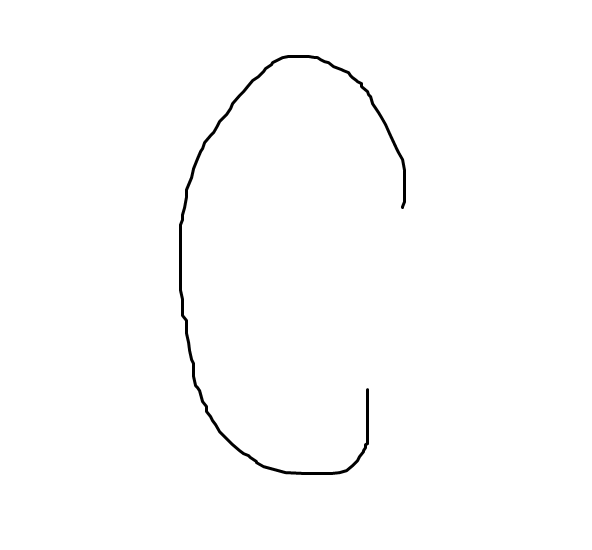

In [ ]:
from IPython.display import display

# Использование метода .predict() обученной модели на подготовленных данных изображения
predictions = model.predict(img_prepared)

# Нахождение индекса класса с наибольшей вероятностью
predicted_index = np.argmax(predictions[0])

# Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
predicted_letter = chr(predicted_index + 65)

# Выведение предсказанной буквы
print(f"Предсказанная буква: {predicted_letter}")

user_image_path = '/content/Image2.png'

try:
  # Загрузка изображения
  img = Image.open(user_image_path)
  print(f"Отображение изображения из: {user_image_path}")
  display(img)
except FileNotFoundError:
  print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
except Exception as e:
  print(f"Произошла ошибка при попытке отобразить изображение: {e}")

In [ ]:
from PIL import Image

# Путь к тестовому изображению
user_image_path = '/content/Image3.png' # Путь должен быть корректным

try:
	# Загрузка изображения
	img = Image.open(user_image_path)

	# Преобразование в оттенки серого, если это ещё не сделано
	if img.mode != 'L':
		img = img.convert('L')

	# Изменение размера изображения до 28x28 пикселей
	img_resized = img.resize((28, 28))

	# Преобразование изображения в массив numpy
	img_array = np.array(img_resized)

	# Нормализация значений пикселей до [0, 1]
	img_normalized = img_array.astype('float32') / 255.0

	# Изменение формы массива, добавлением измерения каналов и пакетов.
	# Модель ожидает входные данные о форме (размер пакета, высота, ширина, каналы).
	img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавление измерения каналов.
	img_prepared = np.expand_dims(img_prepared, axis=0) # Добавление измерения пакетов.

	# Выведение формы подготовленного изображения.
	print("Форма подготовленного изображения:", img_prepared.shape)

	# На этом этапе изображение(img_prepared) готово к использованию в модели для прогнозирования.

except FileNotFoundError:
	print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
except Exception as e:
	print(f"Произошла ошибка во время обработки изображения: {e}")

Форма подготовленного изображения: (1, 28, 28, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Предсказанная буква: U
Отображение изображения из: /content/Image2.png


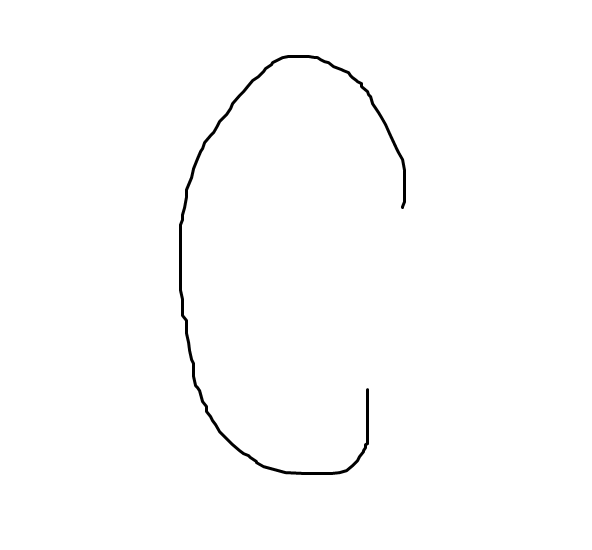

In [ ]:
from IPython.display import display

# Использование метода .predict() обученной модели на подготовленных данных изображения
predictions = model.predict(img_prepared)

# Нахождение индекса класса с наибольшей вероятностью
predicted_index = np.argmax(predictions[0])

# Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
predicted_letter = chr(predicted_index + 65)

# Выведение предсказанной буквы
print(f"Предсказанная буква: {predicted_letter}")

user_image_path = '/content/Image2.png'

try:
  # Загрузка изображения
  img = Image.open(user_image_path)
  print(f"Отображение изображения из: {user_image_path}")
  display(img)
except FileNotFoundError:
  print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
except Exception as e:
  print(f"Произошла ошибка при попытке отобразить изображение: {e}")

In [ ]:
from PIL import Image

# Путь к тестовому изображению
user_image_path = '/content/Image4.png' # Путь должен быть корректным

try:
	# Загрузка изображения
	img = Image.open(user_image_path)

	# Преобразование в оттенки серого, если это ещё не сделано
	if img.mode != 'L':
		img = img.convert('L')

	# Изменение размера изображения до 28x28 пикселей
	img_resized = img.resize((28, 28))

	# Преобразование изображения в массив numpy
	img_array = np.array(img_resized)

	# Нормализация значений пикселей до [0, 1]
	img_normalized = img_array.astype('float32') / 255.0

	# Изменение формы массива, добавлением измерения каналов и пакетов.
	# Модель ожидает входные данные о форме (размер пакета, высота, ширина, каналы).
	img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавление измерения каналов.
	img_prepared = np.expand_dims(img_prepared, axis=0) # Добавление измерения пакетов.

	# Выведение формы подготовленного изображения.
	print("Форма подготовленного изображения:", img_prepared.shape)

	# На этом этапе изображение(img_prepared) готово к использованию в модели для прогнозирования.

except FileNotFoundError:
	print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
except Exception as e:
	print(f"Произошла ошибка во время обработки изображения: {e}")

Форма подготовленного изображения: (1, 28, 28, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Предсказанная буква: U
Отображение изображения из: /content/Image4.png


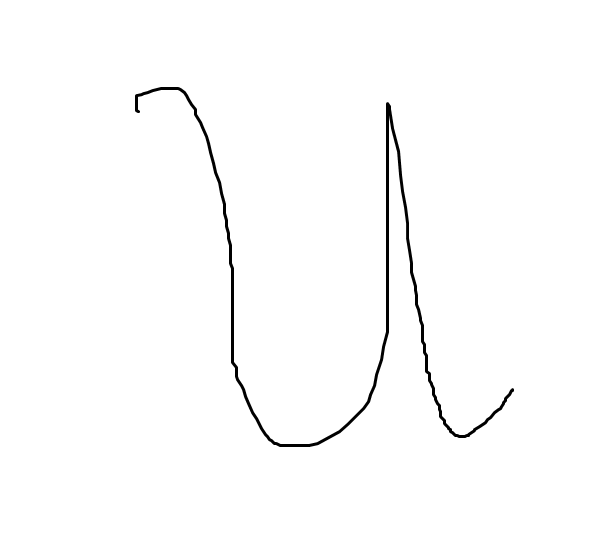

In [ ]:
from IPython.display import display

# Использование метода .predict() обученной модели на подготовленных данных изображения
predictions = model.predict(img_prepared)

# Нахождение индекса класса с наибольшей вероятностью
predicted_index = np.argmax(predictions[0])

# Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
predicted_letter = chr(predicted_index + 65)

# Выведение предсказанной буквы
print(f"Предсказанная буква: {predicted_letter}")

user_image_path = '/content/Image4.png'

try:
  # Загрузка изображения
  img = Image.open(user_image_path)
  print(f"Отображение изображения из: {user_image_path}")
  display(img)
except FileNotFoundError:
  print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
except Exception as e:
  print(f"Произошла ошибка при попытке отобразить изображение: {e}")

Загрузка изображения из: /content/Image1A.png
Загруженное изображение:


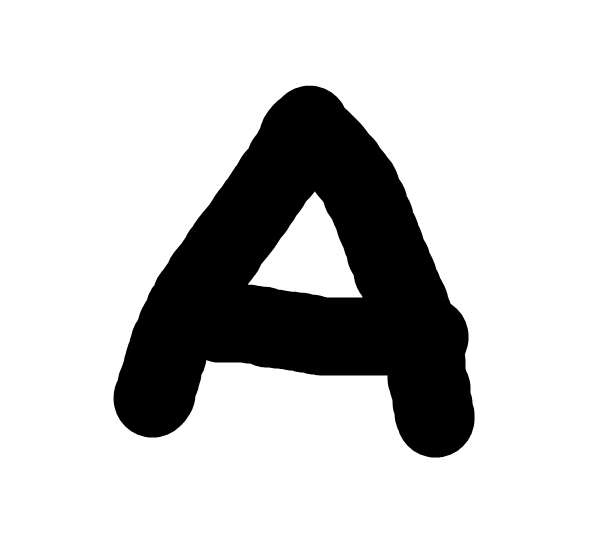

Преобразование изображения в оттенки серого...
Изображение после преобразования в оттенки серого:


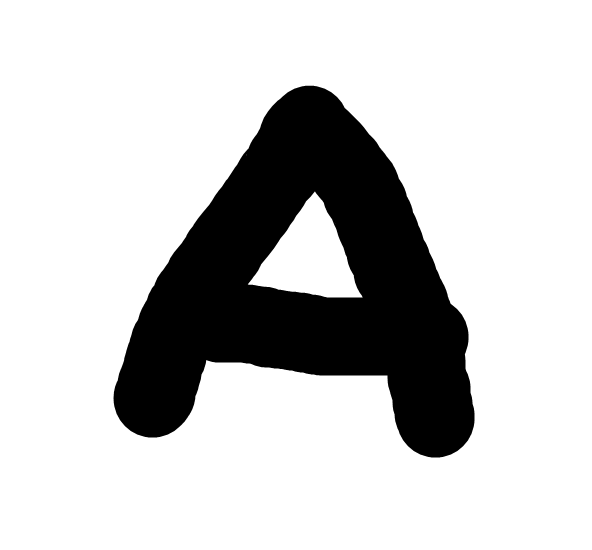

Изменение размера изображения до 28x28 пикселей...
Изображение после изменения размера (28x28):


Преобразование изображения в массив numpy...
Изображение преобразовано в массив numpy с формой: (28, 28), тип данных: uint8
Минимальное значение пикселя: 0, Максимальное значение пикселя: 255
Цвета изображения инвертированы.
Массив после возможной инверсии (первые несколько значений): [0 0 0 0 0 0 0 0 0 0]
Нормализация пиксельных значений к диапазону [0, 1]...
Массив после нормализации (первые несколько значений): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Минимальное значение пикселя после нормализации: 0.0, Максимальное значение пикселя после нормализации: 1.0
Добавление размерностей для канала и батча...
Форма подготовленного изображения для модели: (1, 28, 28, 1)

Выполнение предсказания с помощью модели...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

Предсказанная буква: A
Вероятности предсказания для всех классов (первые 5): [1.0000000e+00 7.0203890e-29 4.3987782e-38 3.6540705e-29 0.0000000e+00]

Пожалуйста, введите фактическую заглавную букву на изображении для сравнения:


Text(value='', description='Фактическая буква:', placeholder='Введите фактическую букву (A-Z)')


Фактическая буква: A
Модель предсказала букву правильно!


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
import string

user_image_path = '/content/Image1A.png'

try:
    # --- Шаг 1: Загрузка изображения ---
    print(f"Загрузка изображения из: {user_image_path}")
    img = Image.open(user_image_path)
    # Отобразим загруженное изображение для проверки
    print("Загруженное изображение:")
    display(img)


    # --- Шаг 2: Преобразование в оттенки серого ---
    if img.mode != 'L':
        print("Преобразование изображения в оттенки серого...")
        img = img.convert('L')
        # Отобразим изображение после преобразования в оттенки серого
        print("Изображение после преобразования в оттенки серого:")
        display(img)
    else:
        print("Изображение уже в оттенках серого.")


    # --- Шаг 3: Изменение размера изображения до 28x28 пикселей ---
    print("Изменение размера изображения до 28x28 пикселей...")
    img_resized = img.resize((28, 28))
    # Отобразим изображение после изменения размера
    print("Изображение после изменения размера (28x28):")
    display(img_resized)


    # --- Шаг 4: Преобразование изображения в массив numpy ---
    print("Преобразование изображения в массив numpy...")
    img_array = np.array(img_resized)
    print(f"Изображение преобразовано в массив numpy с формой: {img_array.shape}, тип данных: {img_array.dtype}")
    print(f"Минимальное значение пикселя: {img_array.min()}, Максимальное значение пикселя: {img_array.max()}")


    # --- Шаг 5: Инвертирование цветов ---
    img_array = 255 - img_array
    print("Цвета изображения инвертированы.")
    print(f"Массив после возможной инверсии (первые несколько значений): {img_array.flatten()[:10]}")


    # --- Шаг 6: Нормализация пиксельных значений к диапазону [0, 1] ---
    print("Нормализация пиксельных значений к диапазону [0, 1]...")
    img_normalized = img_array.astype('float32') / 255.0
    print(f"Массив после нормализации (первые несколько значений): {img_normalized.flatten()[:10]}")
    print(f"Минимальное значение пикселя после нормализации: {img_normalized.min()}, Максимальное значение пикселя после нормализации: {img_normalized.max()}")


    # --- Шаг 7: Добавление размерностей для канала и батча ---
    # Модель ожидает входную форму (batch_size, height, width, channels)
    print("Добавление размерностей для канала и батча...")
    img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавляем измерение канала (1 для оттенков серого)
    img_prepared = np.expand_dims(img_prepared, axis=0)  # Добавляем измерение батча (1 для одного изображения)
    print("Форма подготовленного изображения для модели:", img_prepared.shape)


    # --- Шаг 8: Предсказание с помощью обученной модели ---
    print("\nВыполнение предсказания с помощью модели...")
    predictions = model.predict(img_prepared)

    # Нахождение индекса класса с наибольшей вероятностью
    predicted_index = np.argmax(predictions[0])

    # Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
    predicted_letter = chr(predicted_index + 65)

    # Выведение предсказанной буквы
    print(f"\nПредсказанная буква: {predicted_letter}")
    print(f"Вероятности предсказания для всех классов (первые 5): {predictions[0][:5]}")


    # --- Шаг 9: Сравнение с фактической буквой (пользовательский ввод) ---
    # Этот код остается для сравнения, если вы хотите ввести фактическую букву.
    print("\nПожалуйста, введите фактическую заглавную букву на изображении для сравнения:")

    # Создаем виджет для ввода текста
    actual_letter_input = widgets.Text(
        value='',
        placeholder='Введите фактическую букву (A-Z)',
        description='Фактическая буква:',
        disabled=False
    )
    display(actual_letter_input)

    # Функция для сравнения и вывода результата при вводе фактической буквы
    def on_submit(sender):
        actual_letter = sender.value.strip().upper()
        if len(actual_letter) == 1 and actual_letter in string.ascii_uppercase:
            print(f"\nФактическая буква: {actual_letter}")
            if predicted_letter == actual_letter:
                print("Модель предсказала букву правильно!")
            else:
                print("Предсказание модели НЕ совпадает с фактической буквой.")
        else:
            print("\nНеверный ввод. Пожалуйста, введите одну заглавную букву (A-Z).")

    actual_letter_input.on_submit(on_submit)


except FileNotFoundError:
    print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
    print("Пожалуйста, загрузите ваше изображение в среду выполнения Colab и убедитесь, что переменная 'user_image_path' указывает на верное местоположение.")
except Exception as e:
    print(f"Произошла ошибка во время обработки или предсказания изображения: {e}")

Загрузка изображения из: /content/Image4U.png
Загруженное изображение:


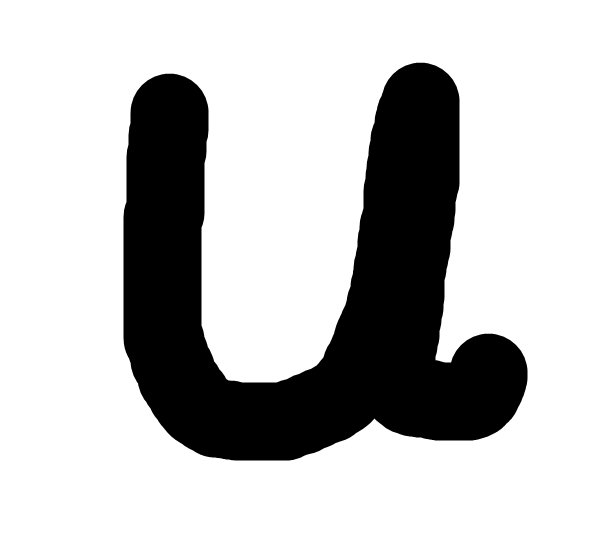

Преобразование изображения в оттенки серого...
Изображение после преобразования в оттенки серого:


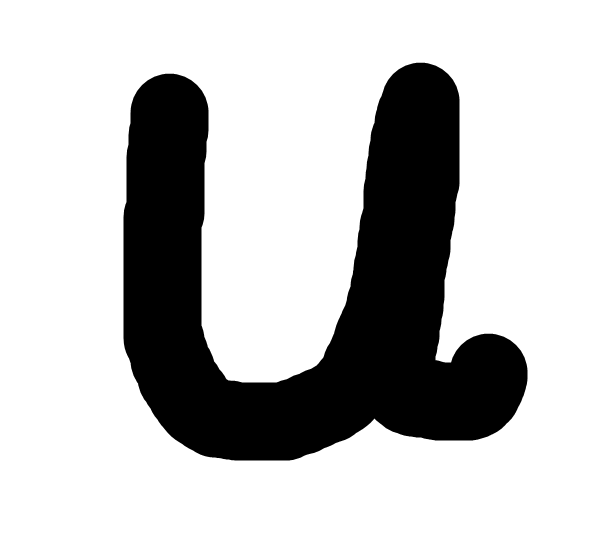

Изменение размера изображения до 28x28 пикселей...
Изображение после изменения размера (28x28):


Преобразование изображения в массив numpy...
Изображение преобразовано в массив numpy с формой: (28, 28), тип данных: uint8
Минимальное значение пикселя: 0, Максимальное значение пикселя: 255
Цвета изображения инвертированы.
Массив после возможной инверсии (первые несколько значений): [0 0 0 0 0 0 0 0 0 0]
Нормализация пиксельных значений к диапазону [0, 1]...
Массив после нормализации (первые несколько значений): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Минимальное значение пикселя после нормализации: 0.0, Максимальное значение пикселя после нормализации: 1.0
Добавление размерностей для канала и батча...
Форма подготовленного изображения для модели: (1, 28, 28, 1)

Выполнение предсказания с помощью модели...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Предсказанная буква: U
Вероятности предсказания для всех классов (первые 5): [8.2883689e-22 6.0204280e-30 9.6669377e-14 4.7817526e-24 1.3794842e-28]

Пожалуйста, введите фактическую заглавную букву на изображении для сравнения:


Text(value='', description='Фактическая буква:', placeholder='Введите фактическую букву (A-Z)')


Фактическая буква: U
Модель предсказала букву правильно!


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
import string

user_image_path = '/content/Image4U.png'

try:
    # --- Шаг 1: Загрузка изображения ---
    print(f"Загрузка изображения из: {user_image_path}")
    img = Image.open(user_image_path)
    # Отобразим загруженное изображение для проверки
    print("Загруженное изображение:")
    display(img)


    # --- Шаг 2: Преобразование в оттенки серого ---
    if img.mode != 'L':
        print("Преобразование изображения в оттенки серого...")
        img = img.convert('L')
        # Отобразим изображение после преобразования в оттенки серого
        print("Изображение после преобразования в оттенки серого:")
        display(img)
    else:
        print("Изображение уже в оттенках серого.")


    # --- Шаг 3: Изменение размера изображения до 28x28 пикселей ---
    print("Изменение размера изображения до 28x28 пикселей...")
    img_resized = img.resize((28, 28))
    # Отобразим изображение после изменения размера
    print("Изображение после изменения размера (28x28):")
    display(img_resized)


    # --- Шаг 4: Преобразование изображения в массив numpy ---
    print("Преобразование изображения в массив numpy...")
    img_array = np.array(img_resized)
    print(f"Изображение преобразовано в массив numpy с формой: {img_array.shape}, тип данных: {img_array.dtype}")
    print(f"Минимальное значение пикселя: {img_array.min()}, Максимальное значение пикселя: {img_array.max()}")


    # --- Шаг 5: Инвертирование цветов ---
    img_array = 255 - img_array
    print("Цвета изображения инвертированы.")
    print(f"Массив после возможной инверсии (первые несколько значений): {img_array.flatten()[:10]}")


    # --- Шаг 6: Нормализация пиксельных значений к диапазону [0, 1] ---
    print("Нормализация пиксельных значений к диапазону [0, 1]...")
    img_normalized = img_array.astype('float32') / 255.0
    print(f"Массив после нормализации (первые несколько значений): {img_normalized.flatten()[:10]}")
    print(f"Минимальное значение пикселя после нормализации: {img_normalized.min()}, Максимальное значение пикселя после нормализации: {img_normalized.max()}")


    # --- Шаг 7: Добавление размерностей для канала и батча ---
    # Модель ожидает входную форму (batch_size, height, width, channels)
    print("Добавление размерностей для канала и батча...")
    img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавляем измерение канала (1 для оттенков серого)
    img_prepared = np.expand_dims(img_prepared, axis=0)  # Добавляем измерение батча (1 для одного изображения)
    print("Форма подготовленного изображения для модели:", img_prepared.shape)


    # --- Шаг 8: Предсказание с помощью обученной модели ---
    print("\nВыполнение предсказания с помощью модели...")
    predictions = model.predict(img_prepared)

    # Нахождение индекса класса с наибольшей вероятностью
    predicted_index = np.argmax(predictions[0])

    # Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
    predicted_letter = chr(predicted_index + 65)

    # Выведение предсказанной буквы
    print(f"\nПредсказанная буква: {predicted_letter}")
    print(f"Вероятности предсказания для всех классов (первые 5): {predictions[0][:5]}")


    # --- Шаг 9: Сравнение с фактической буквой (пользовательский ввод) ---
    # Этот код остается для сравнения, если вы хотите ввести фактическую букву.
    print("\nПожалуйста, введите фактическую заглавную букву на изображении для сравнения:")

    # Создаем виджет для ввода текста
    actual_letter_input = widgets.Text(
        value='',
        placeholder='Введите фактическую букву (A-Z)',
        description='Фактическая буква:',
        disabled=False
    )
    display(actual_letter_input)

    # Функция для сравнения и вывода результата при вводе фактической буквы
    def on_submit(sender):
        actual_letter = sender.value.strip().upper()
        if len(actual_letter) == 1 and actual_letter in string.ascii_uppercase:
            print(f"\nФактическая буква: {actual_letter}")
            if predicted_letter == actual_letter:
                print("Модель предсказала букву правильно!")
            else:
                print("Предсказание модели НЕ совпадает с фактической буквой.")
        else:
            print("\nНеверный ввод. Пожалуйста, введите одну заглавную букву (A-Z).")

    actual_letter_input.on_submit(on_submit)


except FileNotFoundError:
    print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
    print("Пожалуйста, загрузите ваше изображение в среду выполнения Colab и убедитесь, что переменная 'user_image_path' указывает на верное местоположение.")
except Exception as e:
    print(f"Произошла ошибка во время обработки или предсказания изображения: {e}")

Загрузка изображения из: /content/Image2C.png
Загруженное изображение:


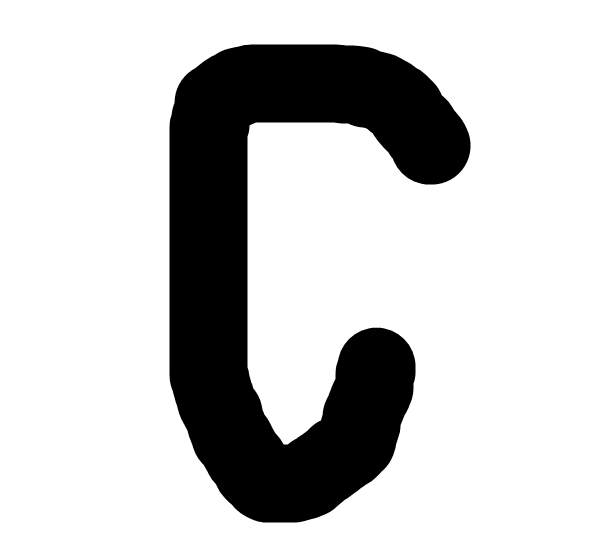

Преобразование изображения в оттенки серого...
Изображение после преобразования в оттенки серого:


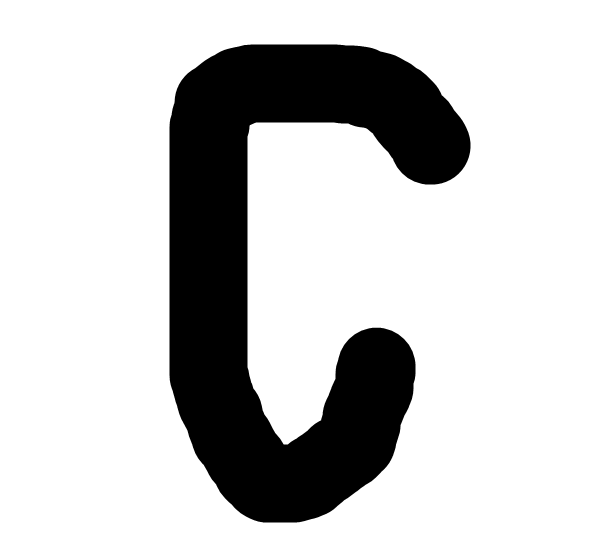

Изменение размера изображения до 28x28 пикселей...
Изображение после изменения размера (28x28):


Преобразование изображения в массив numpy...
Изображение преобразовано в массив numpy с формой: (28, 28), тип данных: uint8
Минимальное значение пикселя: 0, Максимальное значение пикселя: 255
Цвета изображения инвертированы.
Массив после возможной инверсии (первые несколько значений): [0 0 0 0 0 0 0 0 0 0]
Нормализация пиксельных значений к диапазону [0, 1]...
Массив после нормализации (первые несколько значений): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Минимальное значение пикселя после нормализации: 0.0, Максимальное значение пикселя после нормализации: 1.0
Добавление размерностей для канала и батча...
Форма подготовленного изображения для модели: (1, 28, 28, 1)

Выполнение предсказания с помощью модели...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

Предсказанная буква: C
Вероятности предсказания для всех классов (первые 5): [2.9795391e-29 8.0404914e-14 9.5791018e-01 4.5890397e-10 1.3169170e-11]

Пожалуйста, введите фактическую заглавную букву на изображении для сравнения:


Text(value='', description='Фактическая буква:', placeholder='Введите фактическую букву (A-Z)')


Фактическая буква: C
Модель предсказала букву правильно!


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
import string

user_image_path = '/content/Image2C.png'

try:
    # --- Шаг 1: Загрузка изображения ---
    print(f"Загрузка изображения из: {user_image_path}")
    img = Image.open(user_image_path)
    # Отобразим загруженное изображение для проверки
    print("Загруженное изображение:")
    display(img)


    # --- Шаг 2: Преобразование в оттенки серого ---
    if img.mode != 'L':
        print("Преобразование изображения в оттенки серого...")
        img = img.convert('L')
        # Отобразим изображение после преобразования в оттенки серого
        print("Изображение после преобразования в оттенки серого:")
        display(img)
    else:
        print("Изображение уже в оттенках серого.")


    # --- Шаг 3: Изменение размера изображения до 28x28 пикселей ---
    print("Изменение размера изображения до 28x28 пикселей...")
    img_resized = img.resize((28, 28))
    # Отобразим изображение после изменения размера
    print("Изображение после изменения размера (28x28):")
    display(img_resized)


    # --- Шаг 4: Преобразование изображения в массив numpy ---
    print("Преобразование изображения в массив numpy...")
    img_array = np.array(img_resized)
    print(f"Изображение преобразовано в массив numpy с формой: {img_array.shape}, тип данных: {img_array.dtype}")
    print(f"Минимальное значение пикселя: {img_array.min()}, Максимальное значение пикселя: {img_array.max()}")


    # --- Шаг 5: Инвертирование цветов ---
    img_array = 255 - img_array
    print("Цвета изображения инвертированы.")
    print(f"Массив после возможной инверсии (первые несколько значений): {img_array.flatten()[:10]}")


    # --- Шаг 6: Нормализация пиксельных значений к диапазону [0, 1] ---
    print("Нормализация пиксельных значений к диапазону [0, 1]...")
    img_normalized = img_array.astype('float32') / 255.0
    print(f"Массив после нормализации (первые несколько значений): {img_normalized.flatten()[:10]}")
    print(f"Минимальное значение пикселя после нормализации: {img_normalized.min()}, Максимальное значение пикселя после нормализации: {img_normalized.max()}")


    # --- Шаг 7: Добавление размерностей для канала и батча ---
    # Модель ожидает входную форму (batch_size, height, width, channels)
    print("Добавление размерностей для канала и батча...")
    img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавляем измерение канала (1 для оттенков серого)
    img_prepared = np.expand_dims(img_prepared, axis=0)  # Добавляем измерение батча (1 для одного изображения)
    print("Форма подготовленного изображения для модели:", img_prepared.shape)


    # --- Шаг 8: Предсказание с помощью обученной модели ---
    print("\nВыполнение предсказания с помощью модели...")
    predictions = model.predict(img_prepared)

    # Нахождение индекса класса с наибольшей вероятностью
    predicted_index = np.argmax(predictions[0])

    # Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
    predicted_letter = chr(predicted_index + 65)

    # Выведение предсказанной буквы
    print(f"\nПредсказанная буква: {predicted_letter}")
    print(f"Вероятности предсказания для всех классов (первые 5): {predictions[0][:5]}")


    # --- Шаг 9: Сравнение с фактической буквой (пользовательский ввод) ---
    # Этот код остается для сравнения, если вы хотите ввести фактическую букву.
    print("\nПожалуйста, введите фактическую заглавную букву на изображении для сравнения:")

    # Создаем виджет для ввода текста
    actual_letter_input = widgets.Text(
        value='',
        placeholder='Введите фактическую букву (A-Z)',
        description='Фактическая буква:',
        disabled=False
    )
    display(actual_letter_input)

    # Функция для сравнения и вывода результата при вводе фактической буквы
    def on_submit(sender):
        actual_letter = sender.value.strip().upper()
        if len(actual_letter) == 1 and actual_letter in string.ascii_uppercase:
            print(f"\nФактическая буква: {actual_letter}")
            if predicted_letter == actual_letter:
                print("Модель предсказала букву правильно!")
            else:
                print("Предсказание модели НЕ совпадает с фактической буквой.")
        else:
            print("\nНеверный ввод. Пожалуйста, введите одну заглавную букву (A-Z).")

    actual_letter_input.on_submit(on_submit)


except FileNotFoundError:
    print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
    print("Пожалуйста, загрузите ваше изображение в среду выполнения Colab и убедитесь, что переменная 'user_image_path' указывает на верное местоположение.")
except Exception as e:
    print(f"Произошла ошибка во время обработки или предсказания изображения: {e}")

Загрузка изображения из: /content/Image3F.png
Загруженное изображение:


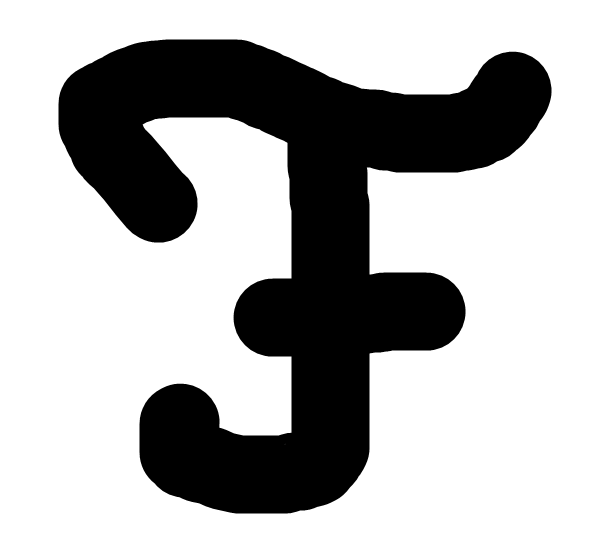

Преобразование изображения в оттенки серого...
Изображение после преобразования в оттенки серого:


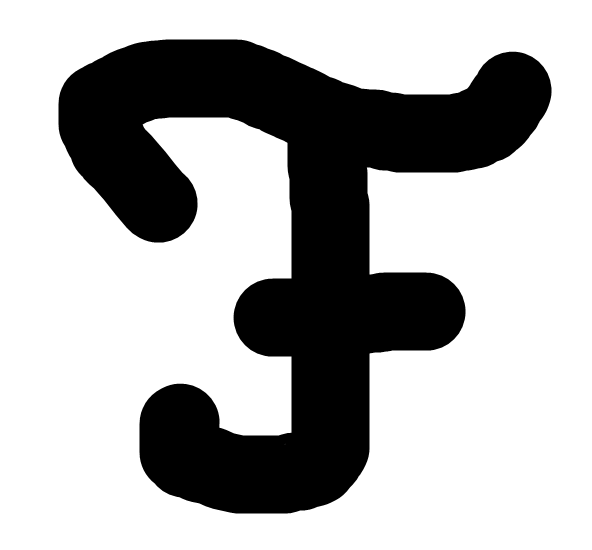

Изменение размера изображения до 28x28 пикселей...
Изображение после изменения размера (28x28):


Преобразование изображения в массив numpy...
Изображение преобразовано в массив numpy с формой: (28, 28), тип данных: uint8
Минимальное значение пикселя: 0, Максимальное значение пикселя: 255
Цвета изображения инвертированы.
Массив после возможной инверсии (первые несколько значений): [0 0 0 0 0 0 0 0 0 0]
Нормализация пиксельных значений к диапазону [0, 1]...
Массив после нормализации (первые несколько значений): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Минимальное значение пикселя после нормализации: 0.0, Максимальное значение пикселя после нормализации: 1.0
Добавление размерностей для канала и батча...
Форма подготовленного изображения для модели: (1, 28, 28, 1)

Выполнение предсказания с помощью модели...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Предсказанная буква: J
Вероятности предсказания для всех классов (первые 5): [3.1407805e-24 1.1723796e-10 2.3339113e-19 3.6845249e-12 3.0500508e-11]

Пожалуйста, введите фактическую заглавную букву на изображении для сравнения:


Text(value='', description='Фактическая буква:', placeholder='Введите фактическую букву (A-Z)')


Фактическая буква: F
Предсказание модели НЕ совпадает с фактической буквой.


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
import string

user_image_path = '/content/Image3F.png'

try:
    # --- Шаг 1: Загрузка изображения ---
    print(f"Загрузка изображения из: {user_image_path}")
    img = Image.open(user_image_path)
    # Отобразим загруженное изображение для проверки
    print("Загруженное изображение:")
    display(img)


    # --- Шаг 2: Преобразование в оттенки серого ---
    if img.mode != 'L':
        print("Преобразование изображения в оттенки серого...")
        img = img.convert('L')
        # Отобразим изображение после преобразования в оттенки серого
        print("Изображение после преобразования в оттенки серого:")
        display(img)
    else:
        print("Изображение уже в оттенках серого.")


    # --- Шаг 3: Изменение размера изображения до 28x28 пикселей ---
    print("Изменение размера изображения до 28x28 пикселей...")
    img_resized = img.resize((28, 28))
    # Отобразим изображение после изменения размера
    print("Изображение после изменения размера (28x28):")
    display(img_resized)


    # --- Шаг 4: Преобразование изображения в массив numpy ---
    print("Преобразование изображения в массив numpy...")
    img_array = np.array(img_resized)
    print(f"Изображение преобразовано в массив numpy с формой: {img_array.shape}, тип данных: {img_array.dtype}")
    print(f"Минимальное значение пикселя: {img_array.min()}, Максимальное значение пикселя: {img_array.max()}")


    # --- Шаг 5: Инвертирование цветов ---
    img_array = 255 - img_array
    print("Цвета изображения инвертированы.")
    print(f"Массив после возможной инверсии (первые несколько значений): {img_array.flatten()[:10]}")


    # --- Шаг 6: Нормализация пиксельных значений к диапазону [0, 1] ---
    print("Нормализация пиксельных значений к диапазону [0, 1]...")
    img_normalized = img_array.astype('float32') / 255.0
    print(f"Массив после нормализации (первые несколько значений): {img_normalized.flatten()[:10]}")
    print(f"Минимальное значение пикселя после нормализации: {img_normalized.min()}, Максимальное значение пикселя после нормализации: {img_normalized.max()}")


    # --- Шаг 7: Добавление размерностей для канала и батча ---
    # Модель ожидает входную форму (batch_size, height, width, channels)
    print("Добавление размерностей для канала и батча...")
    img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавляем измерение канала (1 для оттенков серого)
    img_prepared = np.expand_dims(img_prepared, axis=0)  # Добавляем измерение батча (1 для одного изображения)
    print("Форма подготовленного изображения для модели:", img_prepared.shape)


    # --- Шаг 8: Предсказание с помощью обученной модели ---
    print("\nВыполнение предсказания с помощью модели...")
    predictions = model.predict(img_prepared)

    # Нахождение индекса класса с наибольшей вероятностью
    predicted_index = np.argmax(predictions[0])

    # Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
    predicted_letter = chr(predicted_index + 65)

    # Выведение предсказанной буквы
    print(f"\nПредсказанная буква: {predicted_letter}")
    print(f"Вероятности предсказания для всех классов (первые 5): {predictions[0][:5]}")


    # --- Шаг 9: Сравнение с фактической буквой (пользовательский ввод) ---
    # Этот код остается для сравнения, если вы хотите ввести фактическую букву.
    print("\nПожалуйста, введите фактическую заглавную букву на изображении для сравнения:")

    # Создаем виджет для ввода текста
    actual_letter_input = widgets.Text(
        value='',
        placeholder='Введите фактическую букву (A-Z)',
        description='Фактическая буква:',
        disabled=False
    )
    display(actual_letter_input)

    # Функция для сравнения и вывода результата при вводе фактической буквы
    def on_submit(sender):
        actual_letter = sender.value.strip().upper()
        if len(actual_letter) == 1 and actual_letter in string.ascii_uppercase:
            print(f"\nФактическая буква: {actual_letter}")
            if predicted_letter == actual_letter:
                print("Модель предсказала букву правильно!")
            else:
                print("Предсказание модели НЕ совпадает с фактической буквой.")
        else:
            print("\nНеверный ввод. Пожалуйста, введите одну заглавную букву (A-Z).")

    actual_letter_input.on_submit(on_submit)


except FileNotFoundError:
    print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
    print("Пожалуйста, загрузите ваше изображение в среду выполнения Colab и убедитесь, что переменная 'user_image_path' указывает на верное местоположение.")
except Exception as e:
    print(f"Произошла ошибка во время обработки или предсказания изображения: {e}")

Загрузка изображения из: /content/Image5L.png
Загруженное изображение:


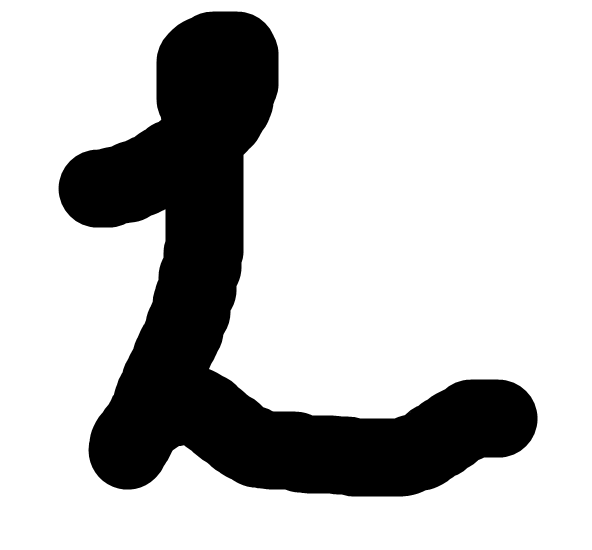

Преобразование изображения в оттенки серого...
Изображение после преобразования в оттенки серого:


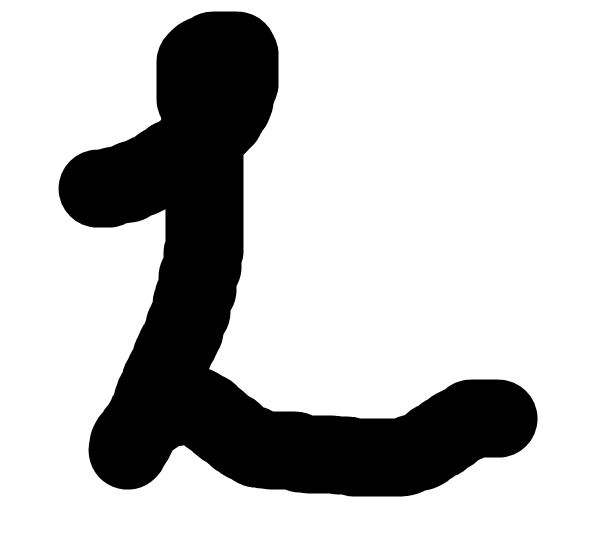

Изменение размера изображения до 28x28 пикселей...
Изображение после изменения размера (28x28):


Преобразование изображения в массив numpy...
Изображение преобразовано в массив numpy с формой: (28, 28), тип данных: uint8
Минимальное значение пикселя: 0, Максимальное значение пикселя: 255
Цвета изображения инвертированы.
Массив после возможной инверсии (первые несколько значений): [ 0  0  0  0  0  0  0  0  4 81]
Нормализация пиксельных значений к диапазону [0, 1]...
Массив после нормализации (первые несколько значений): [0.         0.         0.         0.         0.         0.
 0.         0.         0.01568628 0.31764707]
Минимальное значение пикселя после нормализации: 0.0, Максимальное значение пикселя после нормализации: 1.0
Добавление размерностей для канала и батча...
Форма подготовленного изображения для модели: (1, 28, 28, 1)

Выполнение предсказания с помощью модели...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step

Предсказанная буква: L
Вероятности предсказания для всех классов (первые 5): [7.9663395e-24 1.9246158e-18 2.1365604e-15 8.1981584e-13 9.8564579e-17]

Пожалуйста, введи

Text(value='', description='Фактическая буква:', placeholder='Введите фактическую букву (A-Z)')


Фактическая буква: L
Модель предсказала букву правильно!


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
import string

user_image_path = '/content/Image5L.png'

try:
    # --- Шаг 1: Загрузка изображения ---
    print(f"Загрузка изображения из: {user_image_path}")
    img = Image.open(user_image_path)
    # Отобразим загруженное изображение для проверки
    print("Загруженное изображение:")
    display(img)


    # --- Шаг 2: Преобразование в оттенки серого ---
    if img.mode != 'L':
        print("Преобразование изображения в оттенки серого...")
        img = img.convert('L')
        # Отобразим изображение после преобразования в оттенки серого
        print("Изображение после преобразования в оттенки серого:")
        display(img)
    else:
        print("Изображение уже в оттенках серого.")


    # --- Шаг 3: Изменение размера изображения до 28x28 пикселей ---
    print("Изменение размера изображения до 28x28 пикселей...")
    img_resized = img.resize((28, 28))
    # Отобразим изображение после изменения размера
    print("Изображение после изменения размера (28x28):")
    display(img_resized)


    # --- Шаг 4: Преобразование изображения в массив numpy ---
    print("Преобразование изображения в массив numpy...")
    img_array = np.array(img_resized)
    print(f"Изображение преобразовано в массив numpy с формой: {img_array.shape}, тип данных: {img_array.dtype}")
    print(f"Минимальное значение пикселя: {img_array.min()}, Максимальное значение пикселя: {img_array.max()}")


    # --- Шаг 5: Инвертирование цветов ---
    img_array = 255 - img_array
    print("Цвета изображения инвертированы.")
    print(f"Массив после возможной инверсии (первые несколько значений): {img_array.flatten()[:10]}")


    # --- Шаг 6: Нормализация пиксельных значений к диапазону [0, 1] ---
    print("Нормализация пиксельных значений к диапазону [0, 1]...")
    img_normalized = img_array.astype('float32') / 255.0
    print(f"Массив после нормализации (первые несколько значений): {img_normalized.flatten()[:10]}")
    print(f"Минимальное значение пикселя после нормализации: {img_normalized.min()}, Максимальное значение пикселя после нормализации: {img_normalized.max()}")


    # --- Шаг 7: Добавление размерностей для канала и батча ---
    # Модель ожидает входную форму (batch_size, height, width, channels)
    print("Добавление размерностей для канала и батча...")
    img_prepared = np.expand_dims(img_normalized, axis=-1) # Добавляем измерение канала (1 для оттенков серого)
    img_prepared = np.expand_dims(img_prepared, axis=0)  # Добавляем измерение батча (1 для одного изображения)
    print("Форма подготовленного изображения для модели:", img_prepared.shape)


    # --- Шаг 8: Предсказание с помощью обученной модели ---
    print("\nВыполнение предсказания с помощью модели...")
    predictions = model.predict(img_prepared)

    # Нахождение индекса класса с наибольшей вероятностью
    predicted_index = np.argmax(predictions[0])

    # Сопоставление предсказанного индекса с фактической заглавной буквой (0=A, 1=B, ..., 25=Z)
    predicted_letter = chr(predicted_index + 65)

    # Выведение предсказанной буквы
    print(f"\nПредсказанная буква: {predicted_letter}")
    print(f"Вероятности предсказания для всех классов (первые 5): {predictions[0][:5]}")


    # --- Шаг 9: Сравнение с фактической буквой (пользовательский ввод) ---
    # Этот код остается для сравнения, если вы хотите ввести фактическую букву.
    print("\nПожалуйста, введите фактическую заглавную букву на изображении для сравнения:")

    # Создаем виджет для ввода текста
    actual_letter_input = widgets.Text(
        value='',
        placeholder='Введите фактическую букву (A-Z)',
        description='Фактическая буква:',
        disabled=False
    )
    display(actual_letter_input)

    # Функция для сравнения и вывода результата при вводе фактической буквы
    def on_submit(sender):
        actual_letter = sender.value.strip().upper()
        if len(actual_letter) == 1 and actual_letter in string.ascii_uppercase:
            print(f"\nФактическая буква: {actual_letter}")
            if predicted_letter == actual_letter:
                print("Модель предсказала букву правильно!")
            else:
                print("Предсказание модели НЕ совпадает с фактической буквой.")
        else:
            print("\nНеверный ввод. Пожалуйста, введите одну заглавную букву (A-Z).")

    actual_letter_input.on_submit(on_submit)


except FileNotFoundError:
    print(f"Ошибка: Файл изображения не найден по адресу {user_image_path}")
    print("Пожалуйста, загрузите ваше изображение в среду выполнения Colab и убедитесь, что переменная 'user_image_path' указывает на верное местоположение.")
except Exception as e:
    print(f"Произошла ошибка во время обработки или предсказания изображения: {e}")